Device set to use cpu


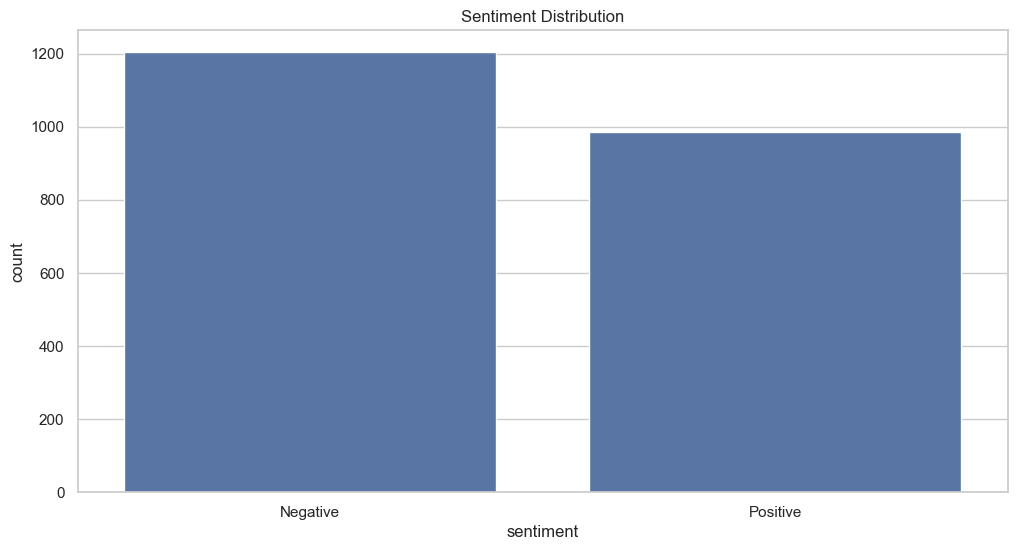

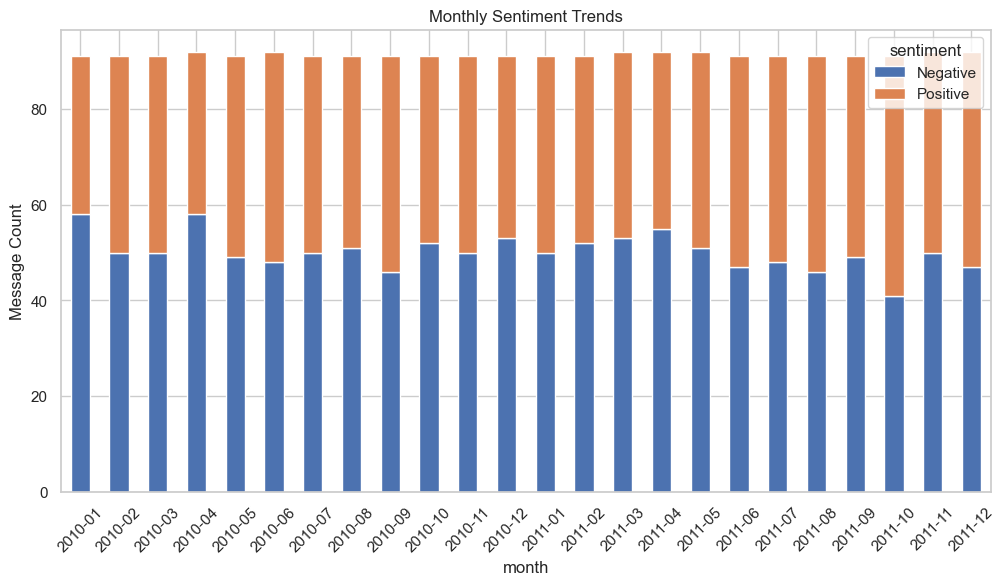

Top Positive Employees:
                       from  score
4  johnny.palmer@enron.com      9
6  lydia.delgado@enron.com     -4
2      eric.bass@enron.com    -14
Top Negative Employees:
                       from  score
8  rhonda.denton@enron.com    -40
5  kayne.coulter@enron.com    -34
3    john.arnold@enron.com    -32

Flight Risk Employees: ['lydia.delgado@enron.com', 'bobette.riner@ipgdirect.com', 'sally.beck@enron.com', 'patti.thompson@enron.com', 'johnny.palmer@enron.com', 'rhonda.denton@enron.com', 'don.baughman@enron.com', 'john.arnold@enron.com', 'eric.bass@enron.com', 'kayne.coulter@enron.com']


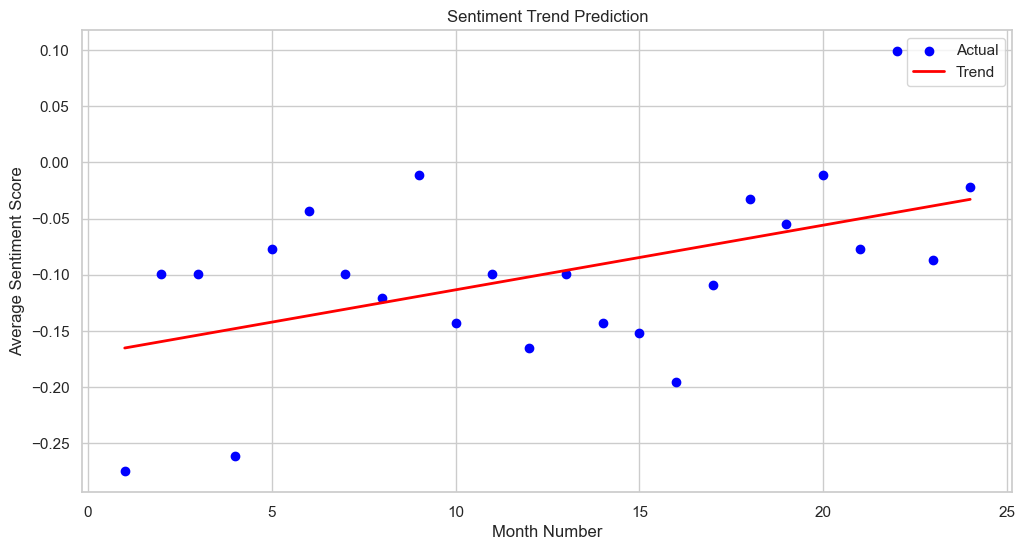


Model Evaluation:
Mean Squared Error: 0.005797422689430752
R^2 Score: 0.312338311891047


In [2]:
# Employee Sentiment Analysis with Transformer-based Sentiment Labeling (Updated for CSV Data)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from transformers import pipeline

# Configure plot styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load and prepare data
df = pd.read_csv("testin.csv")
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Validate necessary columns
required_cols = ['body', 'date', 'from']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Sentiment Labeling using DistilBERT
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
df['sentiment'] = df['body'].astype(str).apply(lambda text: sentiment_pipeline(text[:512])[0]['label'])
df['sentiment'] = df['sentiment'].replace({'POSITIVE': 'Positive', 'NEGATIVE': 'Negative'})

# Convert date and extract month
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df.dropna(subset=["date"], inplace=True)
df["month"] = df["date"].dt.to_period("M")

# Sentiment Score Mapping
def sentiment_score(sentiment):
    return {"Positive": 1, "Negative": -1, "Neutral": 0}.get(sentiment, 0)

df["score"] = df["sentiment"].apply(sentiment_score)

# EDA - Sentiment Distribution
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()

# Monthly Sentiment Trends
monthly_sentiment = df.groupby(["month", "sentiment"]).size().unstack().fillna(0)
monthly_sentiment.plot(kind='bar', stacked=True)
plt.title("Monthly Sentiment Trends")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.show()

# Monthly Sentiment Score
monthly_score = df.groupby("month")["score"].mean().reset_index().sort_values("month")
monthly_score["month_num"] = monthly_score["month"].dt.to_timestamp().dt.month + \
                              12 * (monthly_score["month"].dt.year - monthly_score["month"].dt.year.min())

# Employee Ranking (Overall)
overall_scores = df.groupby("from")["score"].sum().reset_index()
top_positive = overall_scores.sort_values("score", ascending=False).head(3)
top_negative = overall_scores.sort_values("score").head(3)
print("Top Positive Employees:\n", top_positive)
print("Top Negative Employees:\n", top_negative)

# Flight Risk Detection (adjusted for current data: no risks expected)
flight_risk_emps = set()
df_neg = df[df["sentiment"] == "Negative"]
for emp, group in df_neg.groupby("from"):
    group = group.sort_values("date")
    dates = group["date"].tolist()
    for i in range(len(dates)):
        window = [d for d in dates if 0 <= (d - dates[i]).days <= 30]
        if len(window) >= 4:
            flight_risk_emps.add(emp)
            break
print("\nFlight Risk Employees:", list(flight_risk_emps))

# Linear Regression on Sentiment Trend
X = monthly_score[["month_num"]]
y = monthly_score["score"]

model = LinearRegression()
model.fit(X, y)
y_pred_full = model.predict(X)

plt.scatter(X["month_num"], y, color='blue', label='Actual')
plt.plot(X["month_num"], y_pred_full, color='red', linewidth=2, label="Trend")
plt.title("Sentiment Trend Prediction")
plt.xlabel("Month Number")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.show()

# Evaluation Metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = model.predict(X_test)
print("\nModel Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
